#### <b>1. 녹내장 이미지 학습을 위한 데이터 분류</b>

* 이미지를 분류하기 위해 디렉터리를 생성하고 필요한 함수를 정의합니다.

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

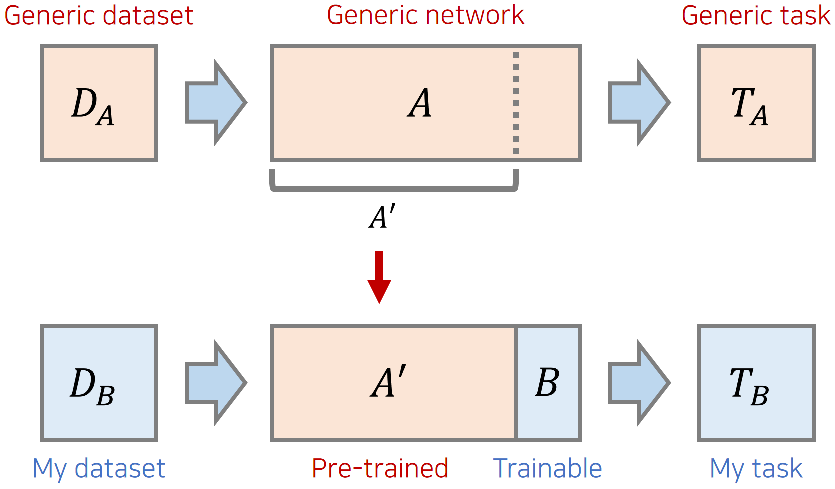

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [1]:
import os
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision import datasets, models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [2]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_dir = './512resized_images'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 3168
테스트 데이터셋 크기: 792
클래스: ['0', '1', '2']


* 간단히 이미지를 시각화해 봅시다.

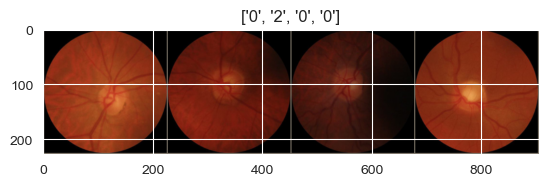

In [3]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()

# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [4]:
model = models.vgg16(pretrained=False)
print(model)

/Users/hansanghyeon/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hansanghyeon/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
num_features = model.classifier[6].in_features

# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.classifier[6] = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

* 학습을 진행합니다.

In [6]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} | Acc: {:.4f}% | Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() - start_time))

#1 Loss: 1.0838 | Acc: 38.6364% | Time: 1263.9372s
#2 Loss: 1.0476 | Acc: 46.3068% | Time: 2531.2283s
#3 Loss: 1.0235 | Acc: 46.7487% | Time: 3789.9599s
#4 Loss: 1.0066 | Acc: 49.5265% | Time: 5066.2657s
#5 Loss: 1.0018 | Acc: 49.2424% | Time: 6331.3305s
#6 Loss: 0.9781 | Acc: 50.0316% | Time: 7605.7324s
#7 Loss: 0.9746 | Acc: 50.9785% | Time: 8878.2220s
#8 Loss: 0.9410 | Acc: 52.4621% | Time: 10119.2918s
#9 Loss: 0.9253 | Acc: 52.2096% | Time: 11348.4367s
#10 Loss: 0.9249 | Acc: 53.0934% | Time: 12576.0204s
#11 Loss: 0.8994 | Acc: 53.4722% | Time: 13801.2931s
#12 Loss: 0.8778 | Acc: 56.5972% | Time: 15024.5312s
#13 Loss: 0.8759 | Acc: 55.9028% | Time: 16241.3123s
#14 Loss: 0.8448 | Acc: 58.9646% | Time: 17458.3225s
#15 Loss: 0.8231 | Acc: 59.9432% | Time: 18705.6845s
#16 Loss: 0.8087 | Acc: 60.1641% | Time: 19963.8292s
#17 Loss: 0.7896 | Acc: 62.8472% | Time: 21228.4954s
#18 Loss: 0.7481 | Acc: 64.0783% | Time: 22494.8852s
#19 Loss: 0.7243 | Acc: 65.9407% | Time: 23771.7120s
#20 Loss:

* 학습된 모델을 평가합니다.

In [7]:
model.eval()
start_time = time.time()

# 모델을 평가할 때 사용할 변수 초기화
y_true = []  # 실제 레이블을 저장할 리스트
y_pred = []  # 모델의 예측 결과를 저장할 리스트
y_pred_perfom = []

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        probabilities = torch.softmax(outputs, dim=1)  # 소프트맥스를 통해 확률값으로 변환

        # 실제 레이블과 모델의 예측 확률을 리스트에 추가 (ROC curve, AUC)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probabilities.cpu().numpy())

        # 실제 레이블과 모델의 예측 결과를 리스트에 추가 (Performance)
        y_pred_perfom.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 0.5230 Acc: 83.0808% Time: 119.8725s


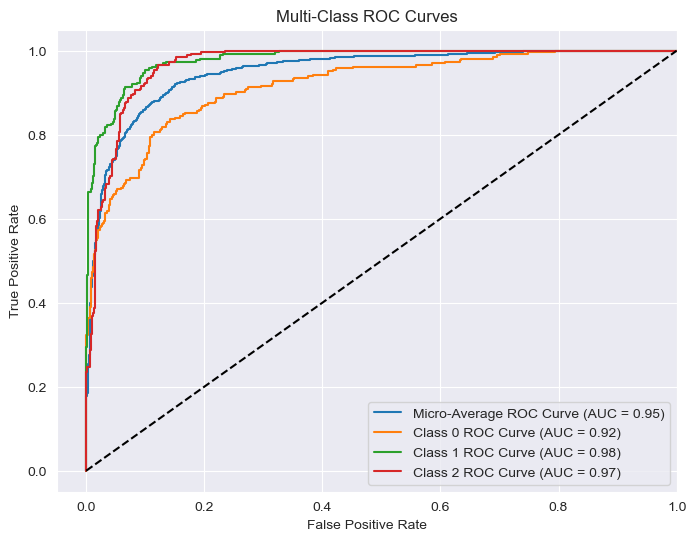

In [8]:
# 각 클래스에 대한 ROC 커브 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_pred)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 모든 클래스의 평균 ROC 커브 및 평균 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(np.array(y_true), classes=np.arange(len(class_names))).ravel(),
                                          np.array(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC 커브 및 AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-Average ROC Curve (AUC = {roc_auc['micro']:.2f})")

for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} ROC Curve (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves")
plt.legend(loc="lower right")
plt.show()

---
### 성능 평가 지표

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score

In [10]:
accuracy = accuracy_score(y_true, y_pred_perfom)
print(f"Multi-Class Accuracy: {accuracy * 100:.2f}%")

Multi-Class Accuracy: 83.08%


In [11]:
# classification_report 출력
target_names = class_names
print("Classification Report")
print(classification_report(y_true, y_pred_perfom, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.62      0.73       264
           1       0.86      0.91      0.88       264
           2       0.77      0.97      0.86       264

    accuracy                           0.83       792
   macro avg       0.84      0.83      0.82       792
weighted avg       0.84      0.83      0.82       792


### Multi-Confusion matrix
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYz4fi%2Fbtqyd71KPB4%2F5B95l7uJvIT8eheYMyd2A1%2Fimg.png" width = "1000" height = "606">

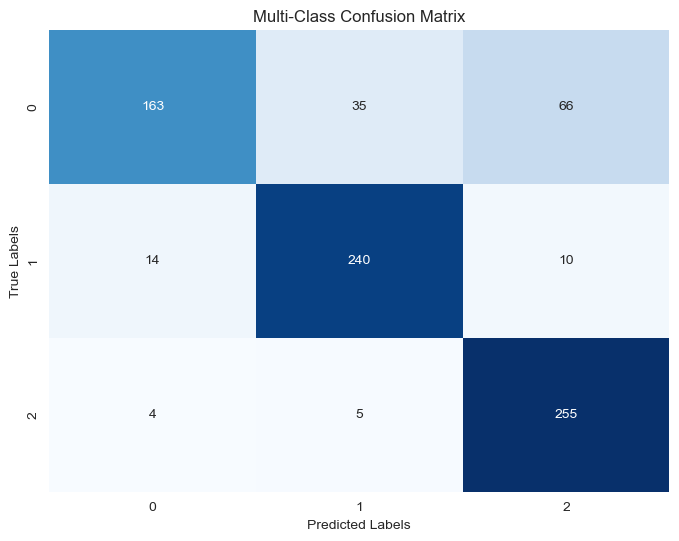

In [12]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_perfom)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Multi-Class Confusion Matrix")
plt.show()

In [13]:
# 카파 통계량 계산
kappa = cohen_kappa_score(y_true, y_pred_perfom)

print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.7462


---

In [14]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,